<a href="https://colab.research.google.com/github/IlyessAgg/mLproject/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

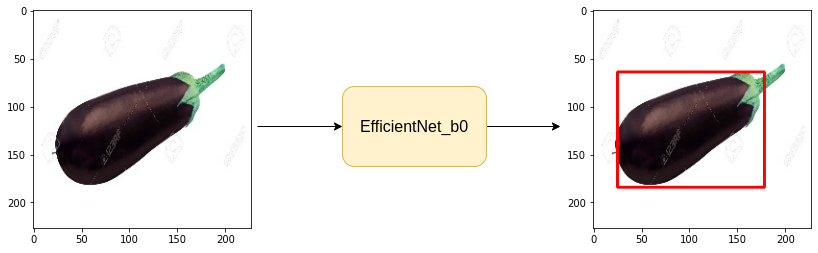

In [ ]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qgnybgdf
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qgnybgdf
  Resolved https://github.com/albumentations-team/albumentations to commit c87c214e0e3b15d1ca278a5a378b0c9ebd4619f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 35.0 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.11-py3-none-any.whl size=165537 sha256=fdf4bd7916d3838d41cc2ea8d2e9c4c0f02f17ff4357b05221e4b967c657c8f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-slvwvd1l/wheels/51/4d/ab/5aafa8b980086fbc362946de7da4a

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COR = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

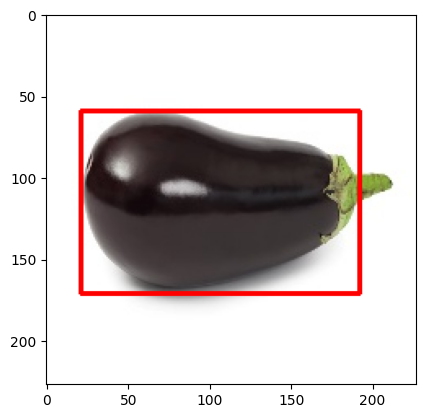

In [ ]:
row = df.iloc[184]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)
plt.imshow(bnd_box_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42 )

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
    A.Rotate()
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 #(h, w, c) -> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox



In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")

Total examples in the trainset : 148
Total examples in the validset : 38


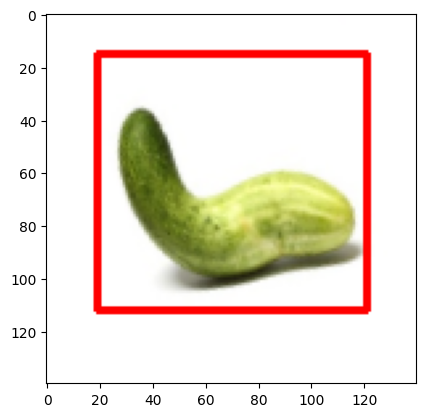

In [ ]:
img, bbox = trainset[34]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes = 4)

  def forward(self, images, gt_bboxes=None):

    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    else:
      return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):

  total_loss = 0.0
  model.train()

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):

  total_loss = 0.0
  model.eval()

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS-ARE-SAVED")
    best_valid_loss = valid_loss

  print(f"Epochs : {i+1} train loss : {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 1 train loss : 5183.430517578125 valid loss: 2233.2625325520835


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 2 train loss : 1904.3815307617188 valid loss: 4472.284505208333


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 3 train loss : 1116.1541931152344 valid loss: 429.35804239908856


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 4 train loss : 745.1295227050781 valid loss: 238.21836853027344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 5 train loss : 524.2925262451172 valid loss: 187.86996459960938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 6 train loss : 417.015478515625 valid loss: 217.94659423828125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 7 train loss : 310.1906204223633 valid loss: 165.05334981282553


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 8 train loss : 226.51768798828124 valid loss: 201.02161661783853


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 9 train loss : 185.28831176757814 valid loss: 155.3170623779297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 10 train loss : 152.52024765014647 valid loss: 173.58548990885416


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 11 train loss : 114.19215087890625 valid loss: 123.94190470377605


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 12 train loss : 124.85278396606445 valid loss: 133.22493998209634


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 13 train loss : 88.28936653137207 valid loss: 122.18346659342448


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 14 train loss : 79.38205108642578 valid loss: 138.27617899576822


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 15 train loss : 81.26057243347168 valid loss: 82.00951894124348


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 16 train loss : 82.23149795532227 valid loss: 85.67593892415364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 17 train loss : 77.68287010192871 valid loss: 139.87177530924478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 18 train loss : 62.823587799072264 valid loss: 83.19969431559245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 19 train loss : 64.50449924468994 valid loss: 74.73399607340495


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 20 train loss : 53.27202224731445 valid loss: 70.27684275309245


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 21 train loss : 60.638906478881836 valid loss: 84.61521657307942


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 22 train loss : 57.24168090820312 valid loss: 68.47812779744466


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 23 train loss : 55.884690856933595 valid loss: 64.95870208740234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 24 train loss : 55.65432624816894 valid loss: 58.54287592569987


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 25 train loss : 44.605330085754396 valid loss: 100.41092681884766


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 26 train loss : 67.7723331451416 valid loss: 68.57315826416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 27 train loss : 61.439678001403806 valid loss: 56.18471908569336


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 28 train loss : 47.454844284057614 valid loss: 58.882057189941406


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 29 train loss : 47.19510459899902 valid loss: 66.84376653035481


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 30 train loss : 56.02307624816895 valid loss: 56.286895751953125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 31 train loss : 42.54746437072754 valid loss: 64.23404312133789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 32 train loss : 40.35832061767578 valid loss: 50.926377614339195


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 33 train loss : 56.51486530303955 valid loss: 54.84537124633789


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 34 train loss : 41.49031295776367 valid loss: 80.82041041056316


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 35 train loss : 39.34340267181396 valid loss: 72.97541046142578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 36 train loss : 47.99744186401367 valid loss: 89.5236218770345


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS-ARE-SAVED
Epochs : 37 train loss : 38.573161125183105 valid loss: 43.88682428995768


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 38 train loss : 60.48525543212891 valid loss: 88.91462707519531


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 39 train loss : 43.46310825347901 valid loss: 66.45779927571614


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs : 40 train loss : 41.5121036529541 valid loss: 89.8165283203125


#Inference

In [ ]:
import utils

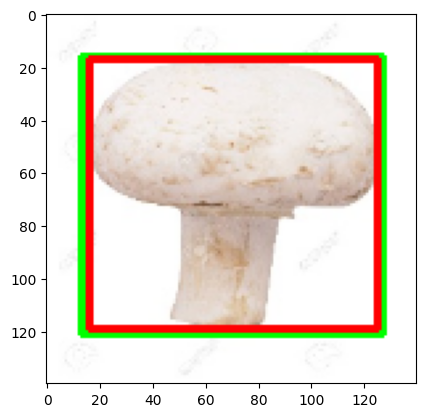

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[1] #(c, h, w)
  image = image.unsqueeze(0).to(DEVICE) #(bs, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)